In [1]:

!rm -rf 


In [2]:
%pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 5.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import random
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [4]:
img_path='/kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/images'
label_path='/kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels'

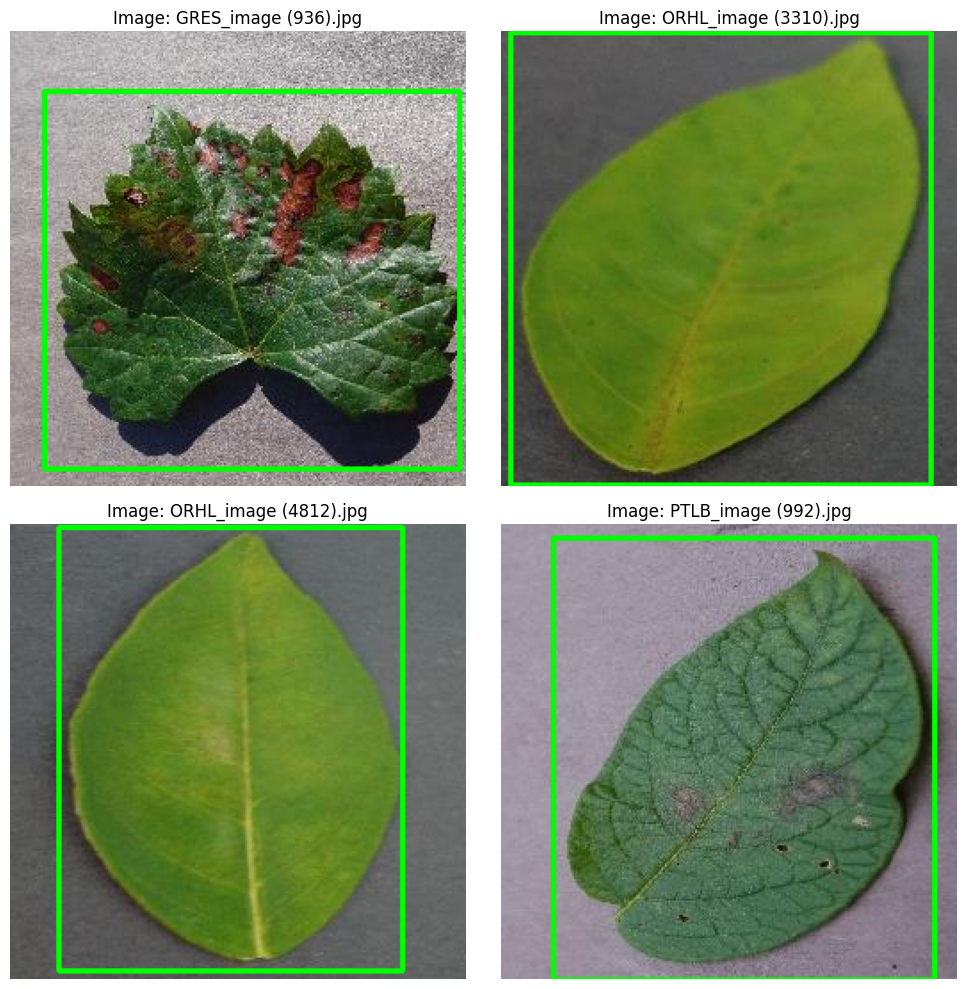

In [5]:
def draw_boxes_from_yolo(img, label_file):
    h, w, _ = img.shape  

    with open(label_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            x_center = int(x_center * w)
            y_center = int(y_center * h)
            width = int(width * w)
            height = int(height * h)
            
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return img

image_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')][:4]

plt.figure(figsize=(10, 10))

for i, image_file in enumerate(image_files):
    img_file = os.path.join(img_path, image_file)
    label_file = os.path.join(label_path, image_file.replace('.jpg', '.txt'))
    
    img = cv2.imread(img_file)
    
    img_with_boxes = draw_boxes_from_yolo(img, label_file)
    
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Image: {image_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

In [7]:
image_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

for i, image_file in enumerate(image_files):
    img_full_path = os.path.join(img_path, image_file)
    label_full_path = os.path.join(label_path, image_file.replace('.jpg', '.txt'))
    
    if os.path.exists(label_full_path):
        if i % 3 == 0:
            copyfile(img_full_path, f'datasets/train/{image_file}')
            copyfile(label_full_path, f'datasets/train/{image_file.replace(".jpg", ".txt")}')
        elif i % 3 == 1:
            copyfile(img_full_path, f'datasets/valid/{image_file}')
            copyfile(label_full_path, f'datasets/valid/{image_file.replace(".jpg", ".txt")}')
        else:
            copyfile(img_full_path, f'datasets/test/{image_file}')
            copyfile(label_full_path, f'datasets/test/{image_file.replace(".jpg", ".txt")}')

In [8]:
import yaml

face_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc = 38,
    names = list(range(38))
)

with open('face.yaml', 'w') as outfile:
    yaml.dump(face_yaml, outfile, default_flow_style=True)

In [9]:
#model = YOLO("yolov8n.pt")
#model = YOLO("yolov8m.pt")
#model = YOLO("yolov9c.pt")
#model = YOLO("yolov9t.pt")
model = YOLO("yolov9m.pt")

model.info()

results = model.train(data="face.yaml", epochs=20, imgsz=640)

100%|██████████| 39.1M/39.1M [00:00<00:00, 180MB/s]


YOLOv9m summary: 603 layers, 20,216,160 parameters, 0 gradients, 77.9 GFLOPs
Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=face.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-09-20 16:58:43,627	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-20 16:58:44,136	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=38

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1    171648  ultralytics.nn.modules.block.RepNCSPELAN4    [64, 128, 128, 64, 1]         
  3                  -1  1    276960  ultralytics.nn.modules.block.AConv           [128, 240]                    
  4                  -1  1    629520  ultralytics.nn.modules.block.RepNCSPELAN4    [240, 240, 240, 120, 1]       
  5                  -1  1    778320  ultralytics.nn.modules.block.AConv           [240, 360]                    
  6                  -1  1   1414080  ultralytics.nn.modules.block.RepNCSPELAN4    [360, 360, 360, 180, 1]       
  7                  -1  1   1556160  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 73.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/train... 18098 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18098/18098 [00:14<00:00, 1259.32it/s]


train: New cache created: /kaggle/working/datasets/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/valid... 18097 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18097/18097 [00:14<00:00, 1253.94it/s]


val: New cache created: /kaggle/working/datasets/valid.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000238, momentum=0.9) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.51G      0.429      1.509      1.135          8        640: 100%|██████████| 1132/1132 [12:40<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:08<00:00,  1.84it/s]


                   all      18097      18115      0.833      0.876      0.946      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.46G     0.3877     0.7466      1.085          4        640: 100%|██████████| 1132/1132 [12:25<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:06<00:00,  1.85it/s]


                   all      18097      18115      0.887      0.864      0.953       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.42G     0.3777     0.6552      1.077          7        640: 100%|██████████| 1132/1132 [12:17<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:05<00:00,  1.85it/s]


                   all      18097      18115      0.899        0.9      0.969      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       8.4G      0.366     0.5852      1.067          5        640: 100%|██████████| 1132/1132 [12:14<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:05<00:00,  1.85it/s]

                   all      18097      18115      0.943      0.934      0.978       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.39G     0.3524     0.5112      1.058          7        640: 100%|██████████| 1132/1132 [12:13<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:04<00:00,  1.86it/s]

                   all      18097      18115      0.955      0.963      0.986      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.41G     0.3371     0.4641      1.049          7        640: 100%|██████████| 1132/1132 [12:12<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:04<00:00,  1.86it/s]

                   all      18097      18115      0.959      0.974      0.988      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.41G     0.3292     0.4259      1.042          6        640: 100%|██████████| 1132/1132 [12:12<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:05<00:00,  1.86it/s]

                   all      18097      18115      0.973      0.975      0.991       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.39G     0.3202     0.4033      1.037          8        640: 100%|██████████| 1132/1132 [12:12<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.971      0.972      0.989      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       8.4G     0.3154     0.3846      1.035          7        640: 100%|██████████| 1132/1132 [12:12<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.87it/s]

                   all      18097      18115      0.975      0.978       0.99      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.41G     0.3114     0.3603      1.032          4        640: 100%|██████████| 1132/1132 [12:12<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.985      0.987      0.992      0.985


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.41G     0.1251      0.189     0.9255          2        640: 100%|██████████| 1132/1132 [12:11<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.989      0.982      0.993      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.39G     0.1153     0.1594     0.9203          2        640: 100%|██████████| 1132/1132 [12:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.981      0.986      0.992      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.41G     0.1119     0.1469      0.919          2        640: 100%|██████████| 1132/1132 [12:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.87it/s]

                   all      18097      18115      0.988      0.989      0.993      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.41G     0.1074     0.1297     0.9175          2        640: 100%|██████████| 1132/1132 [12:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.989      0.987      0.994       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.41G     0.1035     0.1177      0.913          2        640: 100%|██████████| 1132/1132 [12:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:04<00:00,  1.86it/s]

                   all      18097      18115       0.99      0.989      0.993       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.41G    0.09999     0.1064     0.9117          2        640: 100%|██████████| 1132/1132 [12:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.987      0.993      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.41G     0.0977    0.09656     0.9112          2        640: 100%|██████████| 1132/1132 [12:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.992      0.991      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.41G    0.09264    0.08746     0.9066          2        640: 100%|██████████| 1132/1132 [12:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.993       0.99      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.39G    0.08879    0.07905     0.9016          2        640: 100%|██████████| 1132/1132 [12:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:03<00:00,  1.86it/s]

                   all      18097      18115      0.992      0.992      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.41G    0.08529    0.07328     0.9019          2        640: 100%|██████████| 1132/1132 [12:13<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:14<00:00,  1.80it/s]

                   all      18097      18115      0.994      0.991      0.993      0.991



20 epochs completed in 5.788 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 374 layers, 20,040,466 parameters, 0 gradients, 76.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 566/566 [05:02<00:00,  1.87it/s]


                   all      18097      18115      0.992      0.992      0.994      0.991
                     0        221        221          1      0.995      0.995      0.989
                     1        213        213      0.995          1      0.995      0.995
                     2         93         93      0.996          1      0.995      0.995
                     3        567        567      0.996          1      0.995      0.993
                     4        505        505      0.999          1      0.995      0.994
                     5        345        345      0.999          1      0.995      0.995
                     6        275        275      0.999          1      0.995      0.995
                     7        150        152      0.869      0.954      0.965      0.955
                     8        376        376          1      0.997      0.995      0.995
                     9        317        318       0.98       0.92      0.987      0.967
                    1

In [10]:
#!yolo task=detect mode=train model=yolov8m.pt data=face.yaml epochs=20 imgsz=640
!yolo train model=yolov9m.pt data=face.yaml epochs=20 imgsz=640


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=face.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width